In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from pure_ldp.frequency_oracles.rappor import RAPPORClient, RAPPORServer


In [34]:

# Cargar datos
data_path = '../data/raw/bank-full.csv'
df = pd.read_csv(data_path, sep=';')
df['y'] = df['y'].map({'no': 0, 'yes': 1})
X = df.drop(columns=['y'])
y = df['y']

# Mejores parámetros encontrados
best_params_rf = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

# Crear carpetas para guardar las figuras y resultados
figures_base = 'figures'
results_base = 'results'
os.makedirs(figures_base, exist_ok=True)
os.makedirs(results_base, exist_ok=True)
method = 'RAPPOR'
method_path = os.path.join(figures_base, method)
os.makedirs(method_path, exist_ok=True)
subfolders = ['Original'] + [f'eps_{eps}' for eps in [5, 1, 0.5, 0.1]]
for subfolder in subfolders:
    os.makedirs(os.path.join(method_path, subfolder), exist_ok=True)


In [ ]:

# Función para mapear variables categóricas binarias y meses
def map_binary_columns(df):
    df['default'] = df['default'].map({'no': 0, 'yes': 1})
    df['housing'] = df['housing'].map({'no': 0, 'yes': 1})
    df['loan'] = df['loan'].map({'no': 0, 'yes': 1})
    df['month'] = df['month'].map({
        'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
        'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
        'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
    })
    return df

# Función para convertir variables numéricas en categóricas
def convert_numerics_to_categories(df):
    bins_age = [18, 30, 40, 50, 60, 95]
    labels_age = ['18-30', '31-40', '41-50', '51-60', '61+']
    df['age'] = pd.cut(df['age'], bins=bins_age, labels=labels_age, include_lowest=True)

    bins_balance = [-8019, 0, 72, 448, 1428, 102127]
    labels_balance = ['negative', '0-72', '73-448', '449-1428', '1429+']
    df['balance'] = pd.cut(df['balance'], bins=bins_balance, labels=labels_balance, include_lowest=True)

    bins_day = [1, 7, 14, 21, 31]
    labels_day = ['1-7', '8-14', '15-21', '22-31']
    df['day'] = pd.cut(df['day'], bins=bins_day, labels=labels_day, include_lowest=True)

    bins_duration = [0, 103, 180, 319, 4918]
    labels_duration = ['0-103', '104-180', '181-319', '320+']
    df['duration'] = pd.cut(df['duration'], bins=bins_duration, labels=labels_duration, include_lowest=True)

    bins_campaign = [1, 2, 3, 10, 63]
    labels_campaign = ['1', '2-3', '4-10', '11+']
    df['campaign'] = pd.cut(df['campaign'], bins=bins_campaign, labels=labels_campaign, include_lowest=True)

    bins_pdays = [-1, 0, 30, 90, 871]
    labels_pdays = ['no_contact', '0-30', '31-90', '91+']
    df['pdays'] = pd.cut(df['pdays'], bins=bins_pdays, labels=labels_pdays, include_lowest=True)

    bins_previous = [0, 1, 2, 5, 275]
    labels_previous = ['0', '1-2', '3-5', '6+']
    df['previous'] = pd.cut(df['previous'], bins=bins_previous, labels=labels_previous, include_lowest=True)

    return df

# Función para mapear variables categóricas a valores numéricos
def map_categorical_columns(df, categorical_columns):
    mappings = {}
    for col in categorical_columns:
        df[col] = df[col].astype(str).replace('nan', pd.NA)
        unique_values = sorted(df[col].dropna().unique())
        mappings[col] = {value: idx for idx, value in enumerate(unique_values)}
        df[col] = df[col].map(mappings[col])
    return df, mappings

# Función para aplicar RAPPOR
def apply_rappor(df, epsilon, categorical_columns, cat_mappings):
    df_rappor = df.copy()
    n_samples = len(df)

    for col in categorical_columns:
        d = len(cat_mappings[col])
        # RAPPOR parameters
        m = max(16, d * 2)  # Bloom filter size: at least 16, or 2x domain size
        k = 2  # Number of hash functions per cohort
        num_of_cohorts = 8
        f = RAPPORClient.convert_eps_to_f(None, epsilon)

        # Initialize RAPPOR client and server
        server = RAPPORServer(f=f, m=m, k=k, d=d, num_of_cohorts=num_of_cohorts)
        hash_funcs = server.get_hash_funcs()
        client = RAPPORClient(f=f, m=m, hash_funcs=hash_funcs, num_of_cohorts=num_of_cohorts)

        # Privatize each data point
        for idx in df.index:
            value = df.at[idx, col]
            if pd.notna(value):
                perturbed_data, cohort_num = client.privatise(int(value))
                server.aggregate((perturbed_data, cohort_num))

        # Estimate frequencies for each category
        freqs = np.zeros(d)
        for i in range(d):
            freqs[i] = max(0, server.estimate(i, suppress_warnings=True))  # Ensure non-negative frequencies
        # Normalize frequencies to probabilities
        freq_sum = freqs.sum()
        if freq_sum > 0:
            probs = freqs / freq_sum
        else:
            probs = np.ones(d) / d  # Uniform distribution if estimation fails

        # Sample new indices based on estimated frequencies
        sampled_indices = np.random.choice(range(d), size=n_samples, p=probs)
        df_rappor[col] = sampled_indices

    return df_rappor

# Función para generar matrices de conteo (heatmaps) de feature vs target
def plot_feature_target_count_matrices(X_original, X_privatized, y, categorical_columns, cat_mappings, method, model_name):
    df_privatized = X_privatized.copy()
    df_privatized['y'] = y.reset_index(drop=True)

    for col in categorical_columns:
        if df_privatized[col].isna().all():
            print(f"Skipping {col}: all values are NaN")
            continue

        reverse_mapping = {idx: cat for cat, idx in cat_mappings[col].items()}
        df_privatized[col] = df_privatized[col].map(reverse_mapping)
        
        if df_privatized[col].isna().any():
            print(f"Warning: NaN values found in {col} after mapping. Filling with 'Unknown'")
            df_privatized[col] = df_privatized[col].fillna('Unknown')

        count_matrix = pd.crosstab(df_privatized['y'], df_privatized[col])
        if count_matrix.empty:
            print(f"Skipping {col}: count matrix is empty")
            continue

        categories = list(cat_mappings[col].keys())
        if 'Unknown' in df_privatized[col].values:
            categories = categories + ['Unknown']
        count_matrix = count_matrix.reindex(columns=categories, fill_value=0)
        
        if len(count_matrix) == 1:
            if 0 in count_matrix.index:
                count_matrix.loc[1] = 0
            else:
                count_matrix.loc[0] = 0
            count_matrix = count_matrix.sort_index()
        count_matrix.index = ['y=0', 'y=1']

        plt.figure(figsize=(max(6, len(categories) * 0.5), 3))
        sns.heatmap(count_matrix, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
        plt.title(f'Count Matrix: {col} vs Target ({method}, {model_name})')
        plt.xlabel(f'{col} Categories')
        plt.ylabel('Target (y)')
        plt.tight_layout()
        filepath = os.path.join('figures', method, model_name, f'count_matrix_{col}.png')
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        plt.close()

# Procesamiento completo
def process_data(X, y, categorical_columns, cat_mappings, apply_rappor=False, epsilon=None):
    x = X.copy()
    if apply_rappor and epsilon:
        x = apply_rappor(x, epsilon, categorical_columns, cat_mappings)

    x = pd.get_dummies(x, columns=categorical_columns, drop_first=True, dtype='int64')
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

    smoteenn = SMOTEENN(random_state=42)
    X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train, y_train)

    rf = RandomForestClassifier(**best_params_rf, random_state=42)
    boruta = BorutaPy(rf, n_estimators='auto', verbose=0)
    boruta.fit(X_train_resampled.values, y_train_resampled.values)
    selected_features = X_train_resampled.columns[boruta.support_].tolist()
    return X_train_resampled[selected_features], X_test[selected_features], y_train_resampled, y_test

# Entrenar y evaluar modelo
def evaluate_model(X_train, y_train, X_test, y_test):
    model = RandomForestClassifier(**best_params_rf, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    conf_matrix = confusion_matrix(y_test, y_pred)
    actual_negatives, actual_positives = conf_matrix[0].sum(), conf_matrix[1].sum()
    false_positive_pct = conf_matrix[0][1] / actual_negatives if actual_negatives > 0 else 0
    false_negative_pct = conf_matrix[1][0] / actual_positives if actual_positives > 0 else 0
    return {
        'ROC AUC': roc_auc_score(y_test, y_prob),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'Type I Error': false_positive_pct,
        'Type II Error': false_negative_pct
    }

# Función para ejecutar iteraciones y recolectar resultados
def run_iterations(X, y, X_original, categorical_columns, cat_mappings, method='none', epsilon=None, n_iterations=10):
    results = []
    for i in range(n_iterations):
        print(f"Iteration {i+1}/{n_iterations} for method={method}, epsilon={epsilon}")
        if method == 'rappor':
            X_iter = apply_rappor(X.copy(), epsilon, categorical_columns, cat_mappings)
        else:
            X_iter = X.copy()
            
        if i == 0:
            model_name = f'eps_{epsilon}' if method == 'rappor' else 'Original'
            print(f"Generating count matrices for {model_name}...")
            plot_feature_target_count_matrices(X_original, X_iter, y, categorical_columns, cat_mappings, 'RAPPOR', model_name)

        X_train, X_test, y_train, y_test = process_data(X_iter, y, categorical_columns, cat_mappings)
        metrics = evaluate_model(X_train, y_train, X_test, y_test)
        results.append(metrics)
    return results

# Función para calcular estadísticas (mean, min, max) de los resultados
def compute_statistics(results):
    results_df = pd.DataFrame(results)
    return {
        'mean': results_df.mean().to_dict(),
        'min': results_df.min().to_dict(),
        'max': results_df.max().to_dict()
    }

# Función para guardar resultados en CSV
def save_results_to_csv(stats_dict, method_name):
    data = {}
    for model, stats in stats_dict.items():
        data[f'{model} (mean)'] = stats['mean']
        data[f'{model} (min)'] = stats['min']
        data[f'{model} (max)'] = stats['max']
    df = pd.DataFrame(data).round(4)
    df.to_csv(f'results/{method_name}_results.csv')
    return df

# Función para graficar con bigotes verticales (métricas en el eje X, modelos en la leyenda)
def plot_results_with_whiskers(stats_dict, title, colors):
    metrics = list(stats_dict['Original']['mean'].keys())
    models = list(stats_dict.keys())
    n_metrics = len(metrics)
    n_models = len(models)
    
    plt.figure(figsize=(11, 6))
    x_positions = np.arange(n_metrics) * 1.3
    
    for model_idx, model in enumerate(models):
        means = []
        mins = []
        maxs = []
        for metric in metrics:
            means.append(stats_dict[model]['mean'][metric])
            mins.append(stats_dict[model]['min'][metric])
            maxs.append(stats_dict[model]['max'][metric])
        
        plt.scatter(x_positions + (model_idx - (n_models-1)/2) * 0.15, means, 
                    color=colors[model_idx], label=model, s=85) 
        for metric_idx in range(n_metrics):
            plt.vlines(x_positions[metric_idx] + (model_idx - (n_models-1)/2) * 0.15, 
                       mins[metric_idx], maxs[metric_idx], 
                       color=colors[model_idx], linestyle='-', linewidth=1)
    
    plt.xticks(x_positions, metrics, rotation=45, fontdict={'fontsize': 11})
    plt.yticks(fontsize=11)
    plt.title(title, fontdict={'fontsize': 16, 'weight': 'bold'})
    plt.xlabel('Metrics', fontdict={'fontsize': 13})
    plt.ylabel('Value', fontdict={'fontsize': 13})
    plt.legend(title='Models', bbox_to_anchor=(1, 1), loc='upper left', fontsize=11, title_fontsize=13)  
    plt.tight_layout()
    plt.show()


In [36]:

# Todas las columnas son ahora categóricas
all_categorical_columns = ['default', 'housing', 'loan', 'job', 'marital', 'education', 'contact', 'poutcome',
                           'age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Epsilons y resultados
epsilons = [5, 1, 0.1]
results_rappor_stats = {}
n_iterations = 1

# Preprocesar datos originales
X_original = X.copy()
X = map_binary_columns(X)
X = convert_numerics_to_categories(X)
X, cat_mappings = map_categorical_columns(X, all_categorical_columns)


In [37]:
# Modelo sin privacidad (Original)
print("Running iterations for Original...")
results_original = run_iterations(
    X, y, X_original, all_categorical_columns, cat_mappings, method='none', epsilon=None, n_iterations=n_iterations
)
results_rappor_stats['Original'] = compute_statistics(results_original)


Running iterations for Original...
Iteration 1/1 for method=none, epsilon=None
Generating count matrices for Original...


In [38]:
# Modelos con RAPPOR
for epsilon in epsilons:
    print(f"\nRunning iterations for RAPPOR (ε={epsilon})...")
    results_rappor = run_iterations(
        X, y, X_original, all_categorical_columns, cat_mappings, method='rappor', epsilon=epsilon, n_iterations=n_iterations
    )
    results_rappor_stats[f'ε={epsilon}'] = compute_statistics(results_rappor)



Running iterations for RAPPOR (ε=5)...
Iteration 1/1 for method=rappor, epsilon=5


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.247e+06, tolerance: 1.273e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.124e+06, tolerance: 2.

Generating count matrices for eps_5...

Running iterations for RAPPOR (ε=1)...
Iteration 1/1 for method=rappor, epsilon=1


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.165e+08, tolerance: 1.842e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.121e+09, tolerance: 2.

Generating count matrices for eps_1...

Running iterations for RAPPOR (ε=0.1)...
Iteration 1/1 for method=rappor, epsilon=0.1


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.069e+09, tolerance: 6.652e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.123e+10, tolerance: 1.

Generating count matrices for eps_0.1...


In [39]:
# Guardar resultados en CSVs
print("Saving results to CSVs...")
results_rappor_df = save_results_to_csv(results_rappor_stats, 'RAPPOR')


Saving results to CSVs...


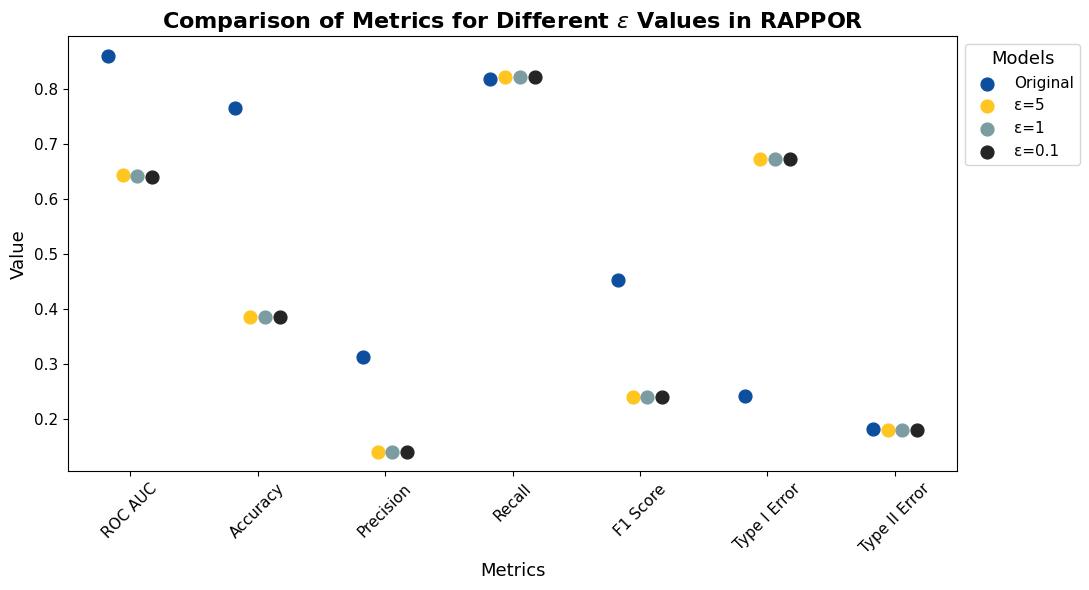

In [40]:
# Colores para los modelos (Original, ε=5, ε=3, ε=1, ε=0.5, ε=0.1)
colors = ['#0d4e9e', '#ffc520', '#7b9ca0', '#242624', '#cc7b4f', '#7764B4']

# Graficar resultados con bigotes verticales
plot_results_with_whiskers(results_rappor_stats, 'Comparison of Metrics for Different $\epsilon$ Values in RAPPOR', colors)